After application of the general ideas from the [Titanic tutorial][1] in [my previous Kernel][2] for this competition, this Kernel builds on those skills and follows the tutorial by *Pedro Marcelino*, [Comprehensive Data Exploration With Python][3]. 
More Tutorials and references are likely to be added as this kernel grows


  [1]: https://www.kaggle.com/startupsci/titanic/titanic-data-science-solutions
  [2]: https://www.kaggle.com/stevejsmith/house-prices-advanced-regression-techniques/house-prices-an-exploratory-investigation
  [3]: https://www.kaggle.com/pmarcelino/house-prices-advanced-regression-techniques/comprehensive-data-exploration-with-python

In [120]:
# Import Functions
import numpy as np # linear algebra
# Stats
from scipy.stats import norm 
from scipy.stats import skew
from scipy import stats
# Model Assistants
from sklearn.preprocessing import StandardScaler
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Graphical Processing
import matplotlib.pyplot as plt
import seaborn as sns

# Warnings
import warnings
warnings.filterwarnings('ignore')
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

%matplotlib inline

sample_submission.csv
test.csv
train.csv



To begin I shall import all the [functions][1] I have already written for this dataset and add a few more based upon repetitive coding in the [tutorial][2] which may help in future analysis


  [1]: https://www.kaggle.com/stevejsmith/house-prices-advanced-regression-techniques/house-prices-an-exploratory-investigation
  [2]: http://%20https://www.kaggle.com/pmarcelino/house-prices-advanced-regression-techniques/comprehensive-data-exploration-with-python

In [121]:
# Return Ordinals for categorical data
def getOrdinals(f1, f2, df):
    """
    Returns the medians as Ordinals
    """
    medians = df[[f1, f2]].groupby([f1], as_index=False).median().sort_values(by=f1, ascending=True)
    medians[f1+'Ords'] = round(medians[f2]/100000,1)
    medians = medians.drop([f2], axis=1)
    return medians

def getOrdinalMeans(f1, f2, df):
    means = df[[f1, f2]].groupby([f1], as_index=False).mean().sort_values(by=f1, ascending=True)
    means[f1+'Ords'] = round(means[f2]/100000,1)
    means = means.drop([f2], axis=1)
    return means


def applyOrdinals(ordinal_df, combined_df):
    """
    Adds a column to the combined dataframe
    """
    # creating a dict
    index1 = ordinal_df.columns.values[0]
    index2 = ordinal_df.columns.values[1]
    val_dict = ordinal_df.set_index(index1).to_dict()
    # creating a column with values from those in the dict
    
    for dataset in combined_df:
        dataset[index2] = dataset[index1].apply(lambda x: val_dict[index2][x])
    
    return combined


def replaceNans(feature, combined_df, replacement):
    for i in range(len(combined_df)):
        combined_df[i].loc[ combined_df[i][feature].isnull(), feature] = replacement
    return combined_df

In [122]:
df_train = pd.read_csv('../input/train.csv')
df_test = pd.read_csv('../input/test.csv')

combined = [df_train, df_test]

In [123]:
# Functions written based on the Tutorial

#========================================
# Descriptive Stats
def featureStats(feature, df, retdata=False):
    # Function for collecting desciptive Stats
    des = df[feature].describe()
    skew = df[feature].skew() 
    kurt = df[feature].kurt()
    if retdata is not False:
        return des, skew, kurt
    else:
        print("Descriptive Stats")
        print(des)
        print("Skewness: %f" % skew)
        print("Kurtosis: %f" % kurt)
    return
#=========================================
# Plots
def scPlot(indf, depf, df, retdata=False):
    # Scatter Plot
    data = pd.concat([df[depf], df[indf]], axis=1)
    fig = data.plot.scatter(x=indf, y=depf)
    if retdata is not False:
        return data
    else:
        pass
    return

def multiScatter(features, df):
    # grid of scatter plots
    sns.set()
    sns.pairplot(df[features], size=3.5)
    plt.show()
    return

def bxPlot(catf, depf, df, retdata=False, xrot=0):
    # box plot
    data = pd.concat([df[depf], df[catf]], axis=1)
    f, ax = plt.subplots(figsize=(12,10))
    fig = sns.boxplot(x=catf, y=depf, data=data)
    plt.xticks(rotation=xrot)
    if retdata is not False:
        return data
    else:
        pass 
    return
 
def corrHeat(df, feature=None, map_vars=10):
    # Correlation Heatmap (feature=None)
    # Correlation Heatmap with vals (feature=feature)
    corrmat = df.corr()
    if (feature is None):
        
        f, ax = plt.subplots(figsize=(12,9))
        sns.heatmap(corrmat, vmax=.8, square=True)
    else:
        cols = corrmat.nlargest(map_vars, feature)[feature].index
        cm = np.corrcoef(df[cols].values.T)
        sns.set(font_scale=1.25)
        hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', \
                         annot_kws={'size': 10}, yticklabels=cols.values, \
                         xticklabels=cols.values)
        plt.show()
        
    return
 


def histNormPlot(feature, df, fit=norm):
    # Plots histogram and normal distribution
    sns.distplot(df[feature], fit=fit)
    fig = plt.figure()
    res = stats.probplot(df[feature], plot=plt)
    return

#=====================================================
# Data operations

def missingData(df):
    # Fetching the columns in a dataframe with missing data
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data.head(20)

def standardizeData(df, feature, retdata=True):
    # data standardization means converting data values 
    # to have mean of 0 and a standard deviation of 1
    feature_scaled = StandardScaler().fit_transform(df[feature][:,np.newaxis])
    low_range = feature_scaled[feature_scaled[:,0].argsort()][:10]
    high_range = feature_scaled[feature_scaled[:,0].argsort()][-10:]
    print('outer range (low) of the distribution:')
    print(low_range)
    print('\nouter range (high) of the distribution:')
    print(high_range)
    if retdata is True:
        return feature_scaled
    else:
        return
    
def fetchOutlierId(df, indf, depf, ifgt, dfgt):
    # Finds the outliers above specified values
    # Use after identifying outliers in a scatter
    # df = datframe to fetch values from
    # indf is independent feature
    # depf is dependent feature
    # ifgt, values of the ifeat greater than ifgt
    # dgft, values of the dfeat greater than ifgt
    vals = df.loc[(df[indf] > ifgt) & (df[depf] > dfgt)]
    data = pd.concat([vals['Id'], vals[indf], vals[depf]], axis=1)
    return data

#===========================================
# Delete Operations
def delPoints(id_list, df):
    for val in id_list:
        df = df.drop(df[df['Id'] == val].index)
    return df

def delColumn(feature, combined_df):
    train_df = combined_df[0]
    test_df = combined_df[1]
    train_df = train_df.drop([feature], axis=1)
    test_df = test_df.drop([feature], axis=1)
    combined = [train_df, test_df]
    return combined

#===========================================
# Restore Operations
def restoreFeature(list_of_features, df):
    """
    Used to restore a Feature to the combined dataframe
    if deleted in error
    """
    fetch_df = pd.read_csv('../input/train.csv')
    fetch_df1 = pd.read_csv('../input/test.csv')   
    for feature in list_of_features:
        df[0][feature] = fetch_df[feature]
        df[1][feature] = fetch_df1[feature]
    return df

def printFunctions():
    useful_functions = {
        'Stats' : {'featureStats(feature, df, retdata=False)'},
        'Plots' : {'scPlot(indf, depf, df, retdata=False)',\
                   'multiScatter(features, df)',\
                   'bxPlot(catf, depf, df, retdata=False, xrot=0)',\
                   'corrHeat(df, feature=None, map_vars=10)',\
                   'histNormPlot(feature, df, fit=norm)'},
        'Data operations' : {'missingData(df)', \
                             'standardizeData(df, feature, retdata=False',\
                             'fetchOutlierId(df, indf, depf, ifgt, dfgt)'},
        'Delete Operations' : {'delPoints(id_list, df)',\
                               'delColumn(feature, combined_df)'},
        'Restore Operations' : {'restoreFeature(list_of_features, df)'},
        'Ordinals' : {'getOrdinals(f1, f2, df)',\
                      'getOrdinalMeans(f1, f2, df)',\
                      'applyOrdinals(ordinal_df, combined_df)'},
        'NaNs' : {'replaceNans(feature, combined_df, replacement)'},
    }
    import pprint
    return pprint.pprint(useful_functions)
# Test
printFunctions()
#histNormPlot('SalePrice', combined[0])
#fetchOutlierId(combined[0], 'GrLivArea', 'SalePrice', 4000, 100000)
#id_list = [524, 1299]
#combined[0] = delPoints(id_list, combined[0])
#fetchOutlierId(combined[0], 'GrLivArea', 'SalePrice', 4000, 100000)

#featureStats('SalePrice', combined[0])
#scPlot('TotalBsmtSF', 'SalePrice', combined[0])
#bxPlot('OverallQual', 'SalePrice', combined[0])
#bxPlot('YearBuilt', 'SalePrice', combined[0], xrot=90)
#corrHeat(combined[0], feature='SalePrice', map_vars=9)
#corrHeat(combined[0])
#features = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars',\
#            'TotalBsmtSF', 'FullBath', 'YearBuilt']
#multiScatter(combined[0], features)
# missingData(combined[0])

#standardizeData(combined[0], 'SalePrice')

{'Data operations': {'fetchOutlierId(df, indf, depf, ifgt, dfgt)',
                     'missingData(df)',
                     'standardizeData(df, feature, retdata=False'},
 'Delete Operations': {'delColumn(feature, combined_df)',
                       'delPoints(id_list, df)'},
 'NaNs': {'replaceNans(feature, combined_df, replacement)'},
 'Ordinals': {'applyOrdinals(ordinal_df, combined_df)',
              'getOrdinalMeans(f1, f2, df)',
              'getOrdinals(f1, f2, df)'},
 'Plots': {'bxPlot(catf, depf, df, retdata=False, xrot=0)',
           'corrHeat(df, feature=None, map_vars=10)',
           'histNormPlot(feature, df, fit=norm)',
           'multiScatter(features, df)',
           'scPlot(indf, depf, df, retdata=False)'},
 'Restore Operations': {'restoreFeature(list_of_features, df)'},
 'Stats': {'featureStats(feature, df, retdata=False)'}}


In [124]:
# Fetching the feature names

combined[0].columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [125]:
# Fetching feature data info
combined[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

Plenty of qualitative (object) features
Some missing values

The aim is to predict SalePrice so this shall be the focus of analysis

In [126]:
featureStats('SalePrice', combined[0])

Descriptive Stats
count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64
Skewness: 1.882876
Kurtosis: 6.536282


Let's look at the distribution

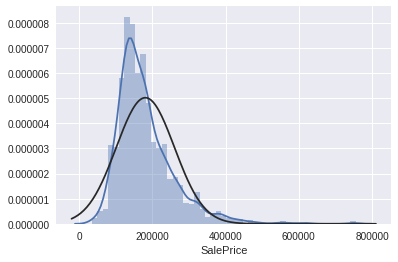

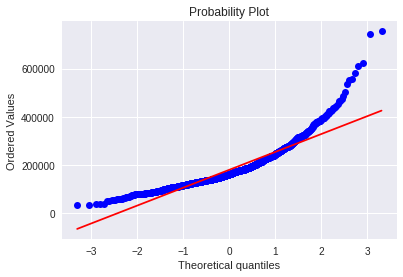

In [127]:
histNormPlot('SalePrice', combined[0])

The values of SalePrice *deviate from the normal distribution*, are *positively skewed* and show *peakedness* as described from the summary statistics.

Standardising this now will provide a better analysis later.

As the data is positively skewed, log transformations may work.

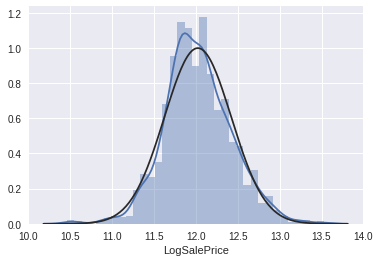

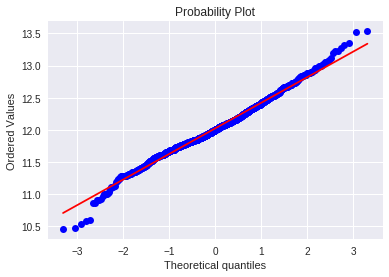

In [128]:
#applying log transformation
combined[0]['LogSalePrice'] = np.log(combined[0]['SalePrice'])

# Fetching the histogram for LogSalePrice
histNormPlot('LogSalePrice', combined[0])

That seems to have worked well.

**Note** predicted sale prices may need to be exp-ed.

Dropping 'SalePrice'

In [129]:
combined[0] = combined[0].drop(['SalePrice'], axis=1)

Filling NAs in data with information from descriptions

In [130]:
combined[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [131]:
# Handle missing values for features where median/mean or most common value doesn't make sense
for dataset in combined:
    # Alley : data description says NA means "no alley access"
    dataset.loc[:, "Alley"] = dataset.loc[:, "Alley"].fillna("None")
    # BedroomAbvGr : NA most likely means 0
    dataset.loc[:, "BedroomAbvGr"] = dataset.loc[:, "BedroomAbvGr"].fillna(0)
    # BsmtQual etc : data description says NA for basement features is "no basement"
    dataset.loc[:, "BsmtQual"] = dataset.loc[:, "BsmtQual"].fillna("No")
    dataset.loc[:, "BsmtCond"] = dataset.loc[:, "BsmtCond"].fillna("No")
    dataset.loc[:, "BsmtExposure"] = dataset.loc[:, "BsmtExposure"].fillna("No")
    dataset.loc[:, "BsmtFinType1"] = dataset.loc[:, "BsmtFinType1"].fillna("No")
    dataset.loc[:, "BsmtFinType2"] = dataset.loc[:, "BsmtFinType2"].fillna("No")
    dataset.loc[:, "BsmtFullBath"] = dataset.loc[:, "BsmtFullBath"].fillna(0)
    dataset.loc[:, "BsmtHalfBath"] = dataset.loc[:, "BsmtHalfBath"].fillna(0)
    dataset.loc[:, "BsmtUnfSF"] = dataset.loc[:, "BsmtUnfSF"].fillna(0)
    dataset.loc[:, "BsmtFinSF1"] = dataset.loc[:, "BsmtFinSF1"].fillna(0)
    dataset.loc[:, "BsmtFinSF2"] = dataset.loc[:, "BsmtFinSF2"].fillna(0)
    dataset.loc[:, "TotalBsmtSF"] = dataset.loc[:, "TotalBsmtSF"].fillna(0)
    

    # CentralAir : NA most likely means No
    dataset.loc[:, "CentralAir"] = dataset.loc[:, "CentralAir"].fillna("N")
    # Condition : NA most likely means Normal
    dataset.loc[:, "Condition1"] = dataset.loc[:, "Condition1"].fillna("Norm")
    dataset.loc[:, "Condition2"] = dataset.loc[:, "Condition2"].fillna("Norm")
    # EnclosedPorch : NA most likely means no enclosed porch
    dataset.loc[:, "EnclosedPorch"] = dataset.loc[:, "EnclosedPorch"].fillna(0)
    # External stuff : NA most likely means average
    dataset.loc[:, "ExterCond"] = dataset.loc[:, "ExterCond"].fillna("TA")
    dataset.loc[:, "ExterQual"] = dataset.loc[:, "ExterQual"].fillna("TA")
    # Electrical
    dataset.loc[:, "Electrical"] = dataset.loc[:, "Electrical"].fillna("SBrkr")
    dataset.loc[:, "Exterior1st"] = dataset.loc[:, "Exterior1st"].fillna("Wd Sdng")
    dataset.loc[:, "Exterior2nd"] = dataset.loc[:, "Exterior2nd"].fillna("Wd Sdng")
    
    # Fence : data description says NA means "no fence"
    dataset.loc[:, "Fence"] = dataset.loc[:, "Fence"].fillna("No")
    # FireplaceQu : data description says NA means "no fireplace"
    dataset.loc[:, "FireplaceQu"] = dataset.loc[:, "FireplaceQu"].fillna("No")
    dataset.loc[:, "Fireplaces"] = dataset.loc[:, "Fireplaces"].fillna(0)
    # Functional : data description says NA means typical
    dataset.loc[:, "Functional"] = dataset.loc[:, "Functional"].fillna("Typ")
    # GarageType etc : data description says NA for garage features is "no garage"
    dataset.loc[:, "GarageType"] = dataset.loc[:, "GarageType"].fillna("No")
    dataset.loc[:, "GarageFinish"] = dataset.loc[:, "GarageFinish"].fillna("No")
    dataset.loc[:, "GarageQual"] = dataset.loc[:, "GarageQual"].fillna("No")
    dataset.loc[:, "GarageCond"] = dataset.loc[:, "GarageCond"].fillna("No")
    dataset.loc[:, "GarageArea"] = dataset.loc[:, "GarageArea"].fillna(0)
    dataset.loc[:, "GarageCars"] = dataset.loc[:, "GarageCars"].fillna(0)
    dataset.loc[:, "GarageYrBlt"] = dataset.loc[:, "GarageYrBlt"].fillna(0)
    # HalfBath : NA most likely means no half baths above grade
    dataset.loc[:, "HalfBath"] = dataset.loc[:, "HalfBath"].fillna(0)
    # HeatingQC : NA most likely means typical
    dataset.loc[:, "HeatingQC"] = dataset.loc[:, "HeatingQC"].fillna("TA")
    # KitchenAbvGr : NA most likely means 0
    dataset.loc[:, "KitchenAbvGr"] = dataset.loc[:, "KitchenAbvGr"].fillna(0)
    # KitchenQual : NA most likely means typical
    dataset.loc[:, "KitchenQual"] = dataset.loc[:, "KitchenQual"].fillna("TA")
    # LotFrontage : NA most likely means no lot frontage
    dataset.loc[:, "LotFrontage"] = dataset.loc[:, "LotFrontage"].fillna(0)
    # LotShape : NA most likely means regular
    dataset.loc[:, "LotShape"] = dataset.loc[:, "LotShape"].fillna("Reg")
    # MasVnrType : NA most likely means no veneer
    dataset.loc[:, "MasVnrType"] = dataset.loc[:, "MasVnrType"].fillna("None")
    dataset.loc[:, "MasVnrArea"] = dataset.loc[:, "MasVnrArea"].fillna(0)
    # MiscFeature : data description says NA means "no misc feature"
    dataset.loc[:, "MiscFeature"] = dataset.loc[:, "MiscFeature"].fillna("No")
    dataset.loc[:, "MiscVal"] = dataset.loc[:, "MiscVal"].fillna(0)
    
    # OpenPorchSF : NA most likely means no open porch
    dataset.loc[:, "OpenPorchSF"] = dataset.loc[:, "OpenPorchSF"].fillna(0)
    # PavedDrive : NA most likely means not paved
    dataset.loc[:, "PavedDrive"] = dataset.loc[:, "PavedDrive"].fillna("N")
    # PoolQC : data description says NA means "no pool"
    dataset.loc[:, "PoolQC"] = dataset.loc[:, "PoolQC"].fillna("No")
    dataset.loc[:, "PoolArea"] = dataset.loc[:, "PoolArea"].fillna(0)
    # SaleCondition : NA most likely means normal sale
    dataset.loc[:, "SaleCondition"] = dataset.loc[:, "SaleCondition"].fillna("Normal")
    # SaleType: 
    dataset.loc[:, "SaleType"] = dataset.loc[:, "SaleType"].fillna("WD")
    # ScreenPorch : NA most likely means no screen porch
    dataset.loc[:, "ScreenPorch"] = dataset.loc[:, "ScreenPorch"].fillna(0)
    # TotRmsAbvGrd : NA most likely means 0
    dataset.loc[:, "TotRmsAbvGrd"] = dataset.loc[:, "TotRmsAbvGrd"].fillna(0)
    # Utilities : NA most likely means all public utilities
    dataset.loc[:, "Utilities"] = dataset.loc[:, "Utilities"].fillna("AllPub")
    # WoodDeckSF : NA most likely means no wood deck
    dataset.loc[:, "WoodDeckSF"] = dataset.loc[:, "WoodDeckSF"].fillna(0)

In [132]:
# Some numerical features are actually really categories
for dataset in combined:
    dataset = dataset.replace({"MSSubClass" : {20 : "SC20", 30 : "SC30", 40 : "SC40", 45 : "SC45", 
                                       50 : "SC50", 60 : "SC60", 70 : "SC70", 75 : "SC75", 
                                       80 : "SC80", 85 : "SC85", 90 : "SC90", 120 : "SC120", 
                                       150 : "SC150", 160 : "SC160", 180 : "SC180", 190 : "SC190"},
                               "MoSold" : {1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 5 : "May", 6 : "Jun",
                                   7 : "Jul", 8 : "Aug", 9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec"}
                              })

In [133]:
# Encode some categorical features as ordered numbers when there is information in the order
for dataset in combined:
    dataset = dataset.replace({"Alley" : {"Grvl" : 1, "Pave" : 2},
                       "BsmtCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "BsmtExposure" : {"No" : 0, "Mn" : 1, "Av": 2, "Gd" : 3},
                       "BsmtFinType1" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtFinType2" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
                       "ExterCond" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "ExterQual" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "FireplaceQu" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, 
                                       "Min2" : 6, "Min1" : 7, "Typ" : 8},
                       "GarageCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "GarageQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "HeatingQC" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "KitchenQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
                       "LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
                       "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2},
                       "PoolQC" : {"No" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
                       "Street" : {"Grvl" : 1, "Pave" : 2},
                       "Utilities" : {"ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, "AllPub" : 4}}
                     )

In [134]:
combined[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1460 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            1460 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non

In [135]:
combined[1].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
Id               1459 non-null int64
MSSubClass       1459 non-null int64
MSZoning         1455 non-null object
LotFrontage      1459 non-null float64
LotArea          1459 non-null int64
Street           1459 non-null object
Alley            1459 non-null object
LotShape         1459 non-null object
LandContour      1459 non-null object
Utilities        1459 non-null object
LotConfig        1459 non-null object
LandSlope        1459 non-null object
Neighborhood     1459 non-null object
Condition1       1459 non-null object
Condition2       1459 non-null object
BldgType         1459 non-null object
HouseStyle       1459 non-null object
OverallQual      1459 non-null int64
OverallCond      1459 non-null int64
YearBuilt        1459 non-null int64
YearRemodAdd     1459 non-null int64
RoofStyle        1459 non-null object
RoofMatl         1459 non-null object
Exterior1st      1459 non

##Looking at the relationship with numerical variables

Examining features likely to correlate

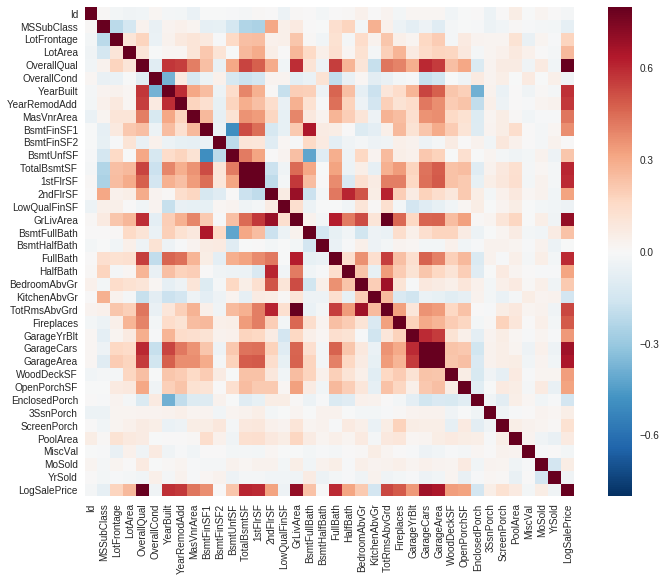

In [136]:
corrHeat(combined[0])

There are some features which correlate strongly with LogSalePrice.
There are some features which correlate, both positively and negatively, with each other.

Examining the features which correlate with LogSalePrice

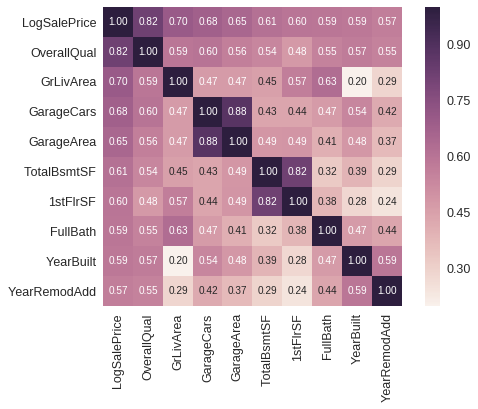

In [137]:
corrHeat(combined[0], feature='LogSalePrice')

**GarageCars** and **GarageArea** are correlated, this is hardly suprising, the ability to garage more cars is dependent upon space.

GarageCars will be dropped.

**1stFlrSF** and **TotalBsmtSF** are correlated. Whilst I am aware that basements can be larger than the floors above (I've seen '24'), normal houses do not have such extravagances. 

1stFlrSF will be dropped

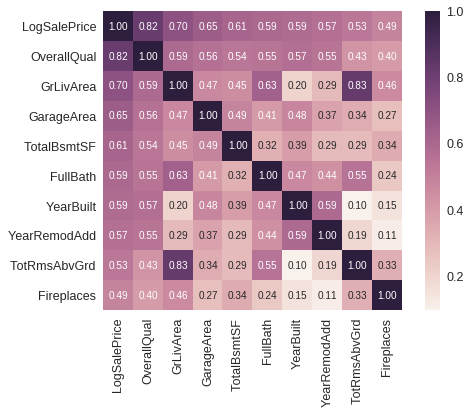

In [138]:
to_drop = ['1stFlrSF', 'GarageCars']
for feature in to_drop:
    combined = delColumn(feature, combined)
    
# Let's check the heatmap again

corrHeat(combined[0], feature='LogSalePrice')



Let's delete  **TotRmsAbvGrd** as this is essentially the same as *GrLivArea*

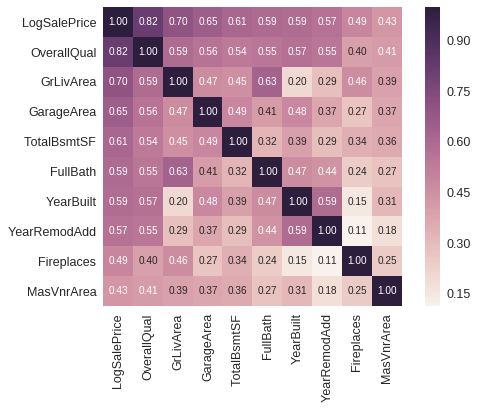

In [139]:
to_drop = ['TotRmsAbvGrd']

for feature in to_drop:
    combined = delColumn(feature, combined)
    
# Checking the Heat Map again

corrHeat(combined[0], feature='LogSalePrice')

Let's plot some scatters of these features

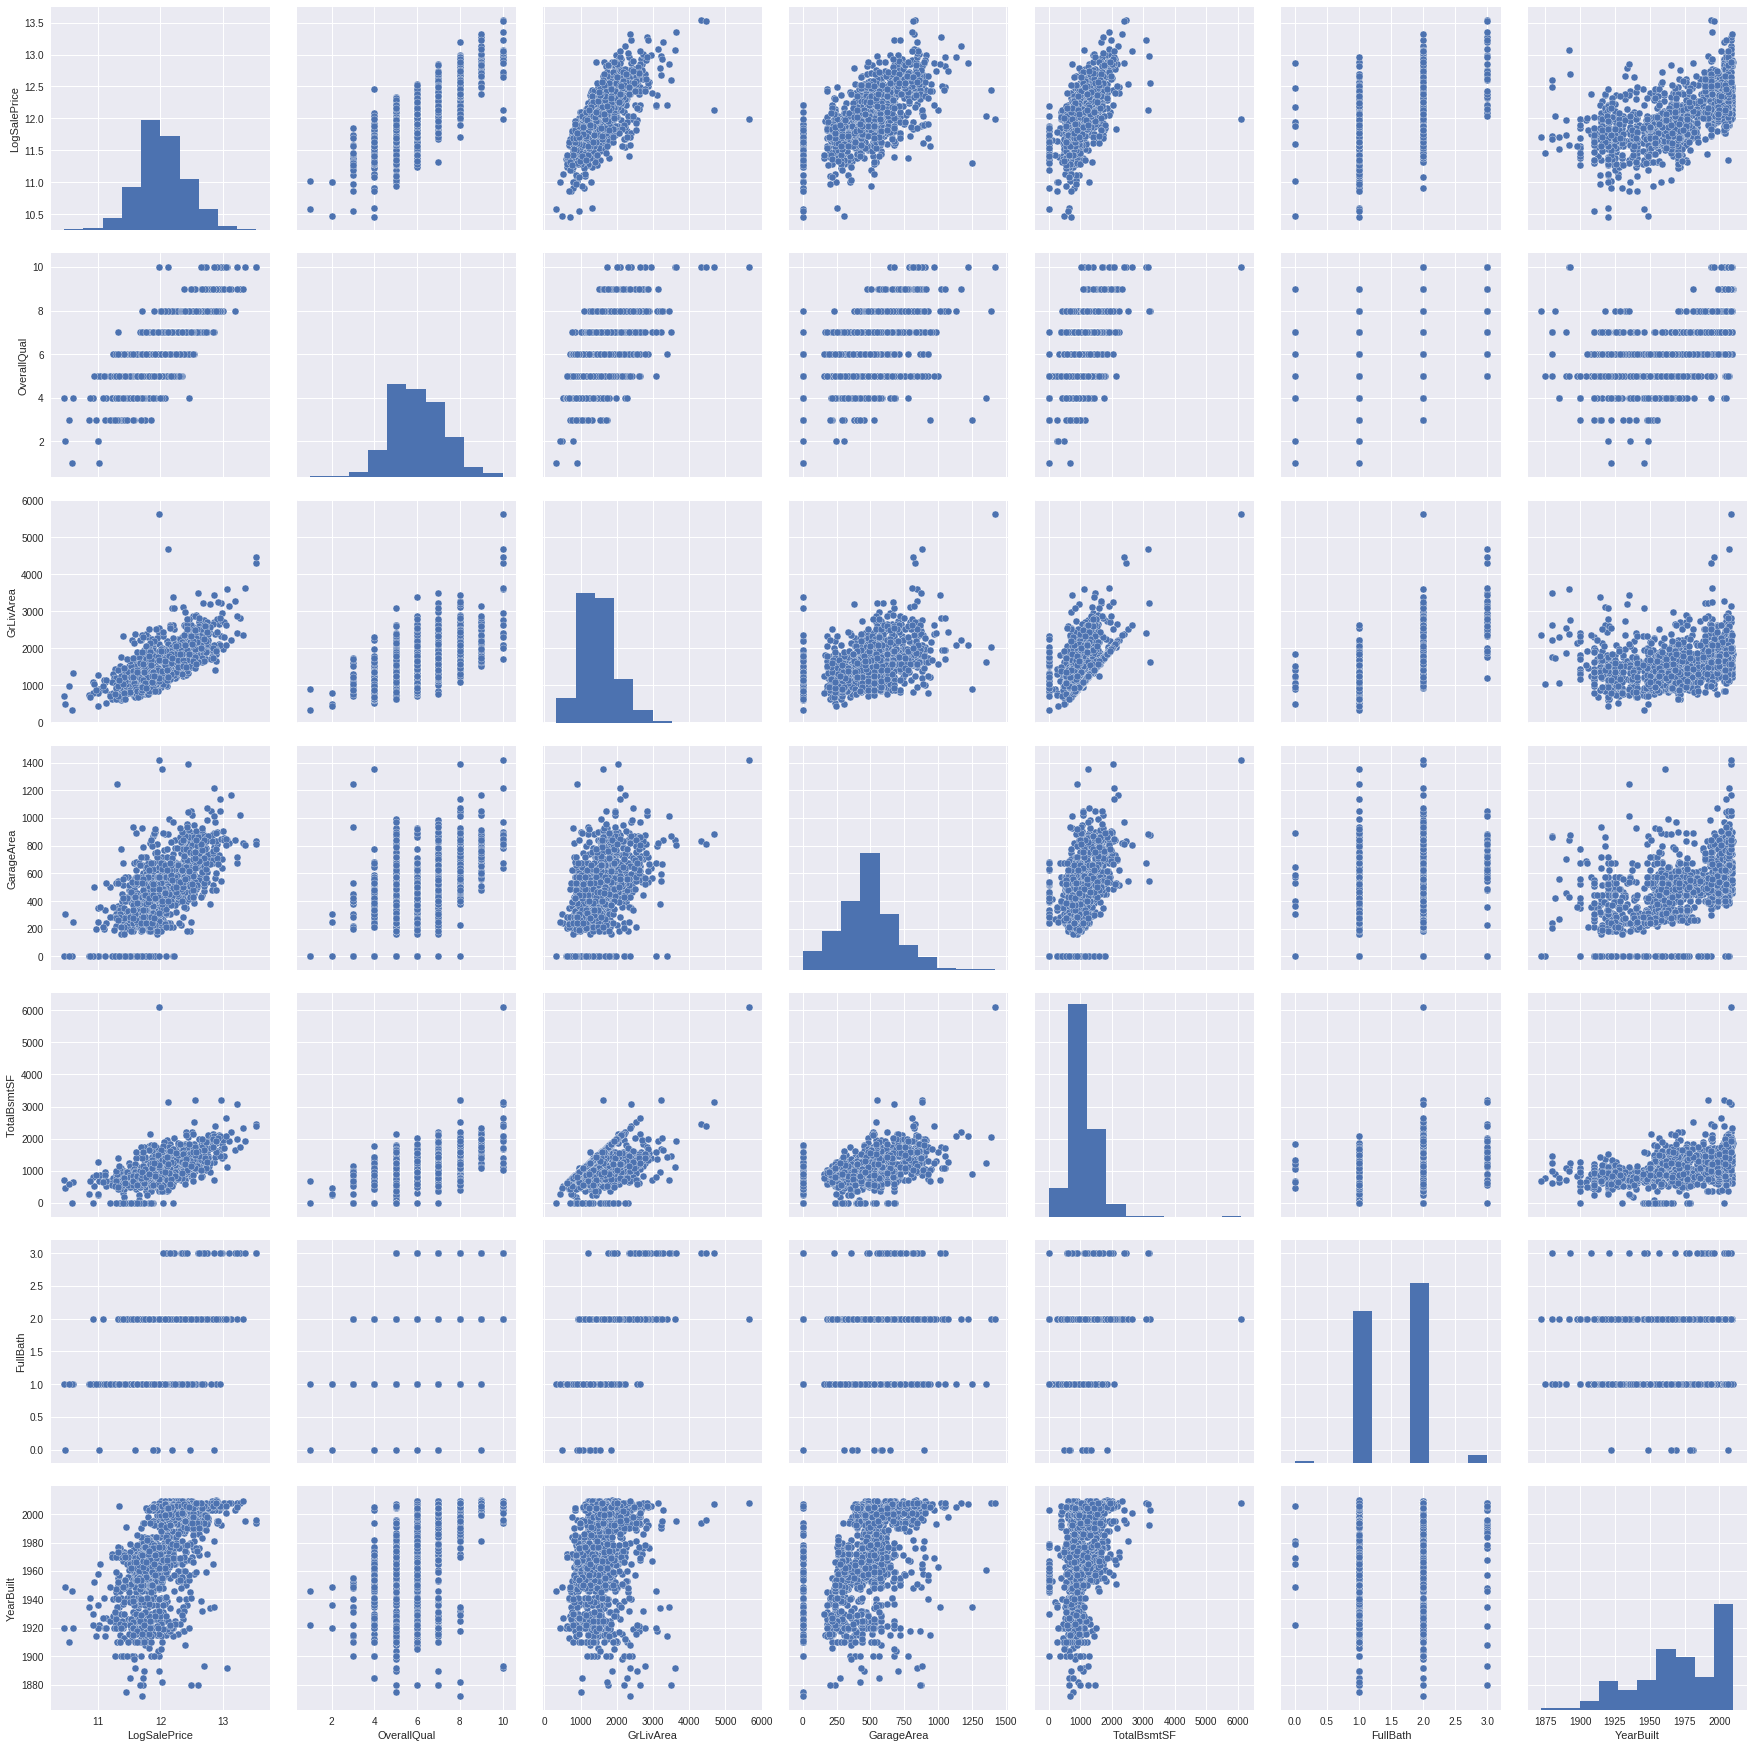

In [140]:

features = ['LogSalePrice', 'OverallQual', 'GrLivArea', 'GarageArea', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
multiScatter(features, combined[0])

Let's investigate **GrLivArea** and **LogSalePrice**

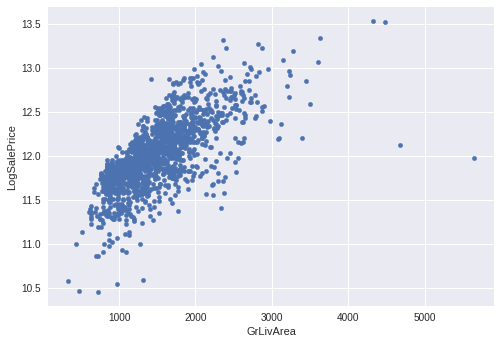

In [141]:
scPlot('GrLivArea', 'LogSalePrice', combined[0])

There appears to be two values that do not represent the trend.
We shall class them as removable outliers.

In [142]:
fetchOutlierId(combined[0], 'GrLivArea', 'LogSalePrice', 4000, 11.5)

,Id,GrLivArea,LogSalePrice
523,524,4676,12.126759
691,692,4316,13.534473
1182,1183,4476,13.521139
1298,1299,5642,11.982929


The identified outliers have Id: 524 and 1299

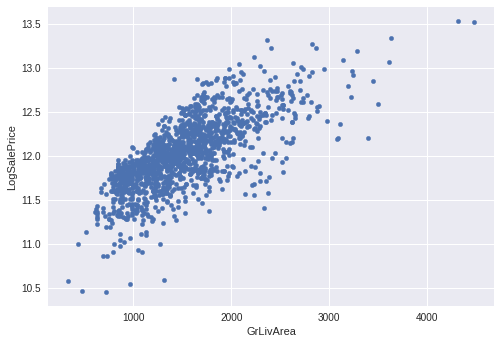

In [143]:
id_list = [524, 1299]
combined[0] = delPoints(id_list, combined[0])

# Plotting again to see if they've been removed
scPlot('GrLivArea', 'LogSalePrice', combined[0])

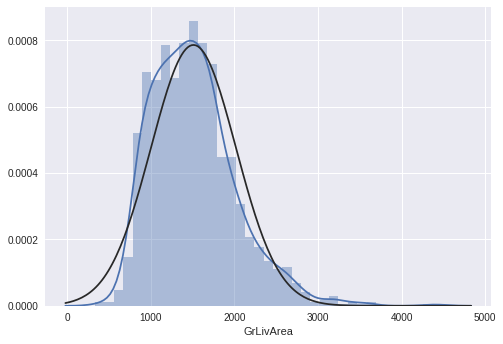

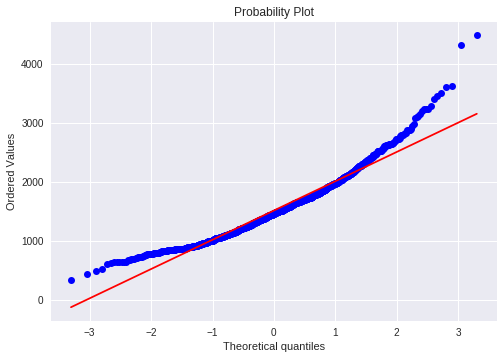

In [144]:
# Checking Normality

histNormPlot('GrLivArea', combined[0])

There is positive skew 

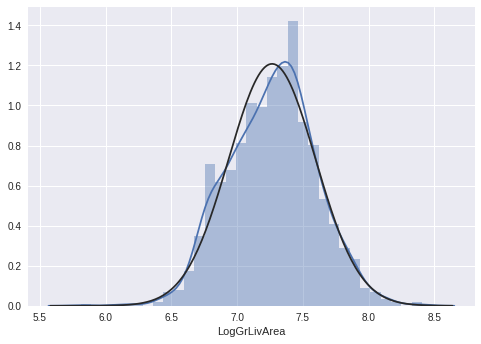

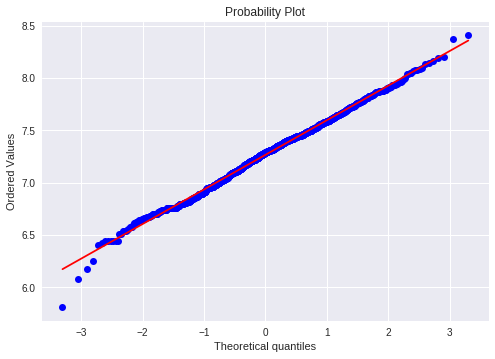

In [145]:
#applying log transformation to data
combined[0]['LogGrLivArea'] = np.log(combined[0]['GrLivArea'])

# Checking Normality

histNormPlot('LogGrLivArea', combined[0])

Much better, applying the transform to the test data and dropping GrLivArea from both

In [146]:
#applying log transformation to test data
combined[1]['LogGrLivArea'] = np.log(combined[1]['GrLivArea'])

# dropping 'GrLivArea
combined = delColumn('GrLivArea', combined)

In [147]:
# Checking correlation
combined[0][['LogGrLivArea','LogSalePrice']].corr()

,LogGrLivArea,LogSalePrice
LogGrLivArea,1.000000,0.737427
LogSalePrice,0.737427,1.000000


A fine result! An improvement, no less from the 0.70 seen in the heat map

Let's investigate **OverallQual** and **LogSalePrice**

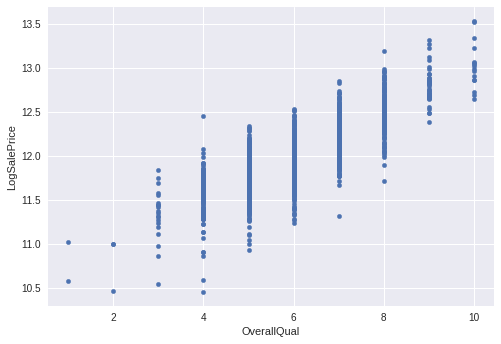

In [148]:
scPlot('OverallQual', 'LogSalePrice', combined[0])

There appears to be a linear trend, looking for normality:

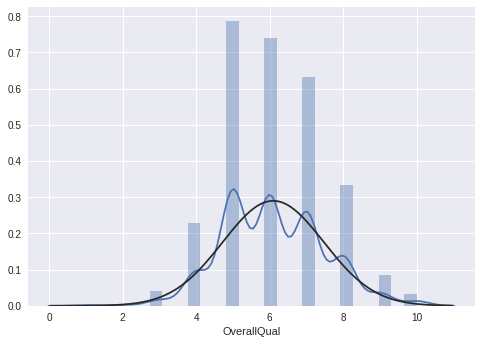

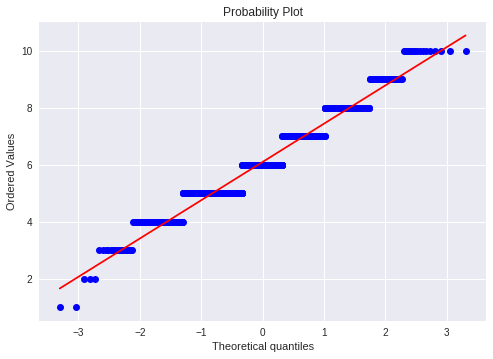

In [149]:
histNormPlot('OverallQual', combined[0])

The data peels away at the extremities, there is some negative skewness, but generally it's a good fit.

To do next: Look at the other features in the scatter grid,  investigate possible exponential relationship in bottom right.

**LogSalePrice** and **GarageArea**

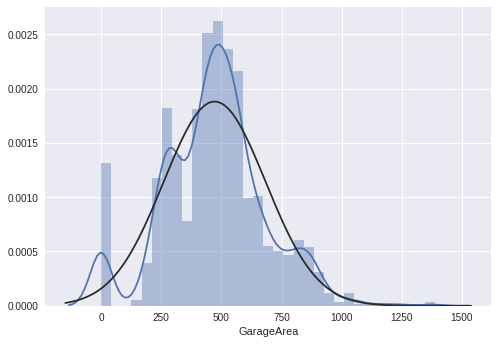

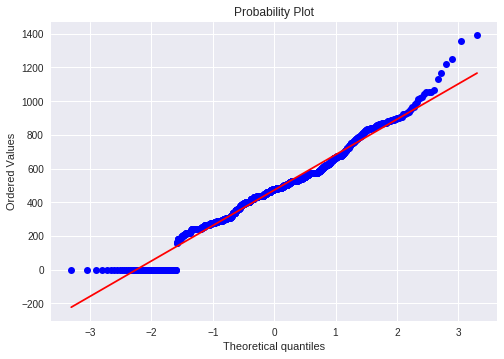

In [150]:
histNormPlot('GarageArea', combined[0])

The distribution has a lot of zero values, the non-zero values appear to follow a normal distribution.
We'll create a variable that can get the effect of having or not having basement (binary variable).

In [151]:
#create column for new variable (one is enough because it's a binary categorical feature)
#if area>0 it gets 1, for area==0 it gets 0
for dataset in combined:
    dataset['HasGarage'] = dataset['GarageArea'].apply(lambda x: 1 if x > 0 else 0)

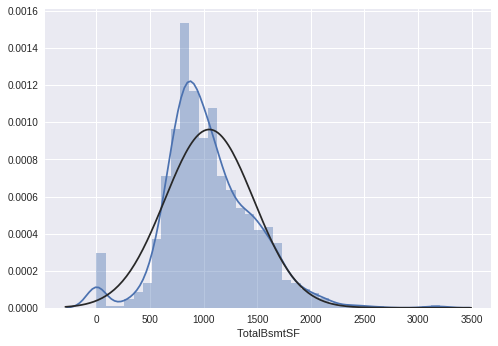

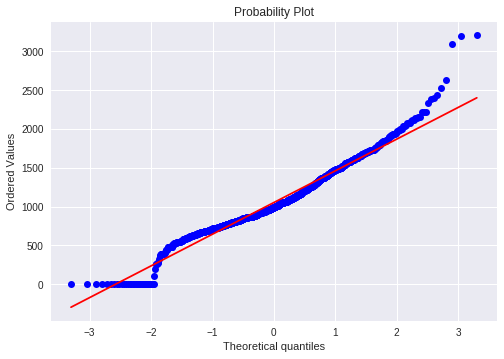

In [152]:
#histogram and normal probability plot

histNormPlot('TotalBsmtSF', combined[0])

In [153]:
#create column for new variable (one is enough because it's a binary categorical feature)
#if area>0 it gets 1, for area==0 it gets 0
for dataset in combined:
    dataset['HasBsmt'] = dataset['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)

In [154]:
#transform data
for dataset in combined:
    dataset.loc[dataset['HasBsmt']==1,'TotalBsmtSF'] = np.log(dataset['TotalBsmtSF'])
    

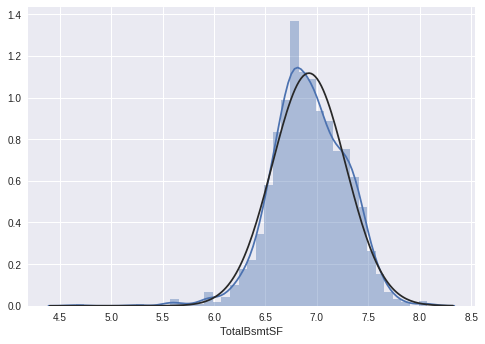

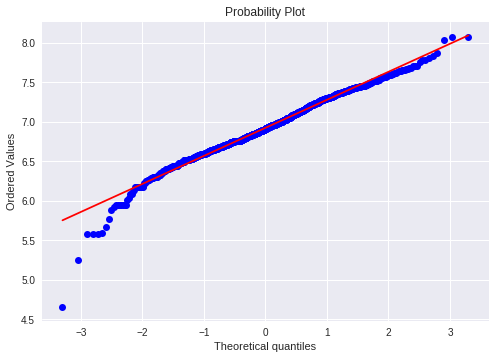

In [155]:
#histogram and normal probability plot
sns.distplot(combined[0][combined[0]['TotalBsmtSF']>0]['TotalBsmtSF'], fit=norm);
fig = plt.figure()
res = stats.probplot(combined[0][combined[0]['TotalBsmtSF']>0]['TotalBsmtSF'], plot=plt)

As TotalBsmtSF has now been transformed when SF>0, delete HasBsmt

In [156]:
combined = delColumn('HasBsmt', combined)

Checking for skewness in other numerical features and applying a log transform

In [157]:
#log transform skewed numeric features:
numeric_feats = combined[0].dtypes[combined[0].dtypes != "object"].index

skewed_feats = combined[0][numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index
skewed_feats

Index(['MSSubClass', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', '2ndFlrSF', 'LowQualFinSF', 'BsmtHalfBath', 'KitchenAbvGr',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal'],
      dtype='object')

In [158]:
for dataset in combined:
    dataset[skewed_feats] = np.log1p(dataset[skewed_feats])

In [159]:
combined[0].head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,LogSalePrice,LogGrLivArea,HasGarage
0,1,4.110874,RL,65.0,9.042040,Pave,None,Reg,Lvl,AllPub,...,No,No,0.0,2,2008,WD,Normal,12.247694,7.444249,1
1,2,3.044522,RL,80.0,9.169623,Pave,None,Reg,Lvl,AllPub,...,No,No,0.0,5,2007,WD,Normal,12.109011,7.140453,1
2,3,4.110874,RL,68.0,9.328212,Pave,None,IR1,Lvl,AllPub,...,No,No,0.0,9,2008,WD,Normal,12.317167,7.487734,1
3,4,4.262680,RL,60.0,9.164401,Pave,None,IR1,Lvl,AllPub,...,No,No,0.0,2,2006,WD,Abnorml,11.849398,7.448334,1
4,5,4.110874,RL,84.0,9.565284,Pave,None,IR1,Lvl,AllPub,...,No,No,0.0,12,2008,WD,Normal,12.429216,7.695303,1


In [160]:
log_sale_price = combined[0]['LogSalePrice']

combined[0] = combined[0].drop('LogSalePrice', axis=1)
all_data = pd.concat((combined[0].loc[:,'MSSubClass':'HasGarage'],
                      combined[1].loc[:,'MSSubClass':'HasGarage']))

In [161]:
all_data = pd.get_dummies(all_data)

In [162]:
#filling NA's with the mean of the column:
all_data = all_data.fillna(all_data.mean())

In [163]:
# split the data

#creating matrices for sklearn:
X_train = all_data[:combined[0].shape[0]]
X_test = all_data[combined[0].shape[0]:]
y = log_sale_price

In [164]:
# https://www.kaggle.com/apapiu/house-prices-advanced-regression-techniques/regularized-linear-models

from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [165]:
model_ridge = Ridge()

In [166]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

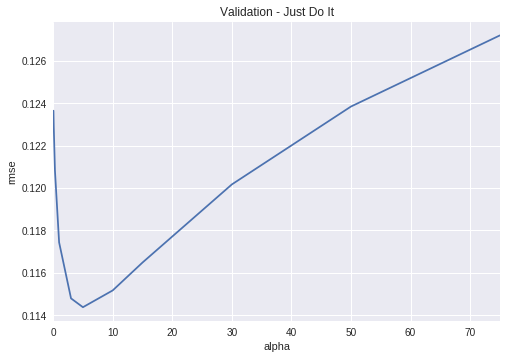

In [167]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [168]:
print(cv_ridge)

0.05     0.123652
0.10     0.122909
0.30     0.120831
1.00     0.117437
3.00     0.114793
5.00     0.114376
10.00    0.115169
15.00    0.116484
30.00    0.120172
50.00    0.123850
75.00    0.127208
dtype: float64


In [169]:
cv_ridge.min()

0.1143755154372165

In [170]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y)
rmse_cv(model_lasso).mean()

0.1115066208817304

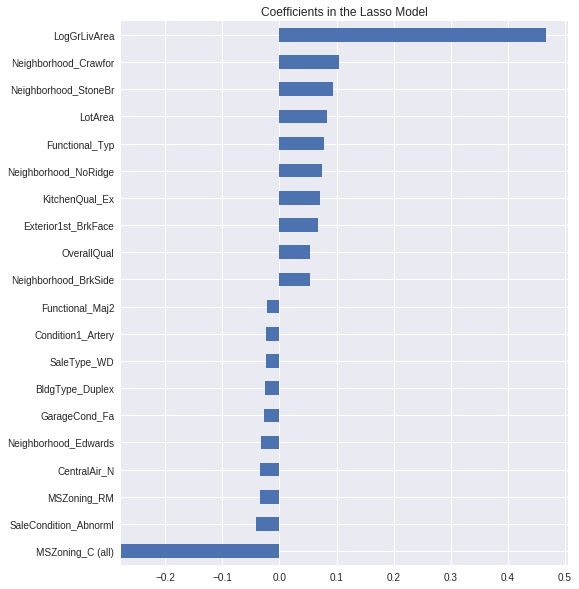

In [171]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])
plt.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

In [172]:
import xgboost as xgb
dtrain = xgb.DMatrix(X_train, label = y)
dtest = xgb.DMatrix(X_test)

params = {"max_depth":2, "eta":0.1}
model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)

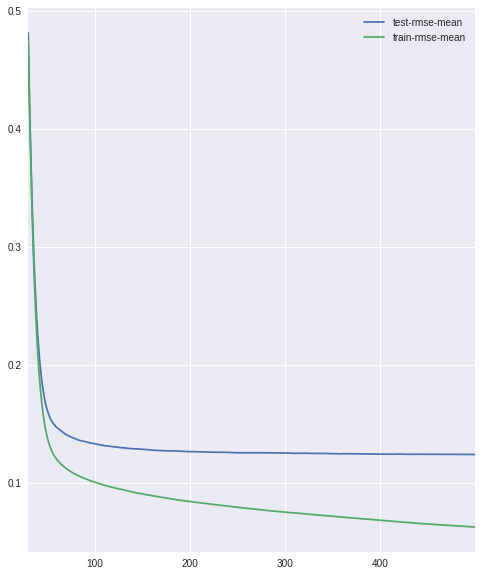

In [173]:
model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()

In [174]:
model_xgb = xgb.XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1) #the params were tuned using xgb.cv
model_xgb.fit(X_train, y)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=360, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [175]:
xgb_preds = np.expm1(model_xgb.predict(X_test))
lasso_preds = np.expm1(model_lasso.predict(X_test))

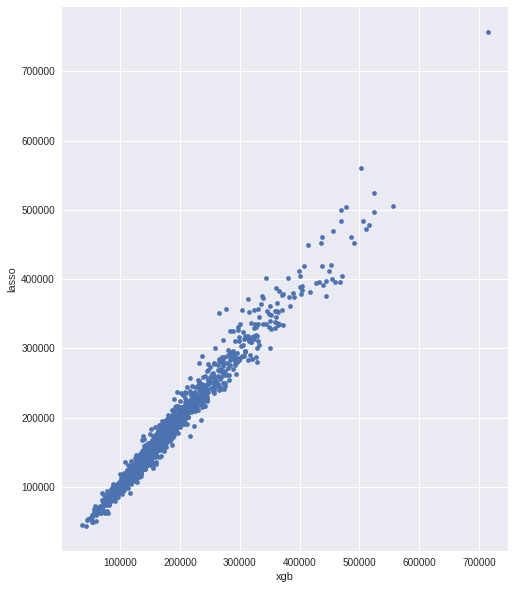

In [176]:
predictions = pd.DataFrame({"xgb":xgb_preds, "lasso":lasso_preds})
predictions.plot(x = "xgb", y = "lasso", kind = "scatter")

In [177]:
preds = 0.7*lasso_preds + 0.3*xgb_preds

In [178]:
solution = pd.DataFrame({"id":combined[1].Id, "SalePrice":preds})
solution.to_csv("ridge_sol.csv", index = False)